In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, Flatten
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import to_categorical

%matplotlib inline   
from matplotlib import pyplot as plt

AE

In [2]:
from zipfile import ZipFile

with ZipFile('data_set.data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [3]:
MaizeData_X = pd.read_csv('data_set.data/dataverse_files/Geno_50K_Drops_012_247I_44729L.tsv', sep='\t')
df_ori = MaizeData_X
df_ori

,SYN83,PZE-101000060,PZE-101000088,PZE-101000108,PZE-101000111,PZE-101000161,PZE-101000169,PZE-101000209,PZE-101000256,PZE-101000301,...,ZM013608-0315,PZE-101235343,PUT-163a-28982443-1666,PZA00086.8,ZM013526-0477,SYNGENTA16702,SYNGENTA1627,PUT-163a-89757491-4674,PUT-163a-18163661-1262,PZA03171.3
11430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A3,0,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,2,2,2,0,0
A310,2,0,0,2,0,0,0,0,2,2,...,0,2,2,2,0,2,0,0,2,0
A347,2,2,0,2,2,0,0,0,2,0,...,0,0,0,0,0,2,0,0,2,0
A374,2,2,0,2,0,2,2,2,0,2,...,0,2,2,2,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W604S,0,0,0,2,2,0,0,2,2,0,...,2,0,0,2,0,2,0,2,2,0
W64A,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,2,2,0,0,0
W9,2,0,0,2,0,0,2,2,0,2,...,0,0,0,2,0,2,0,2,0,0
W95115,0,0,0,2,0,0,0,2,2,0,...,0,2,2,2,0,2,2,2,2,0


In [4]:
df_ori = df_ori.drop(columns=['SYN83'])

Preprocessing

In [5]:
df_onehot = to_categorical(df_ori)
df_onehot.shape

(247, 44728, 3)

In [6]:
train_X, valid_X = train_test_split(df_onehot, test_size=0.2)

train_X.shape, valid_X.shape

((197, 44728, 3), (50, 44728, 3))

Testing a SCDA model on Maize genotype dataset with 10% missing genotypes.

In [7]:
# hyperparameters
missing_perc = 0.05

# training
batch_size = 32
#15
lr = 1e-4
#1e-3
epochs = 50

# conv1D
feature_size = train_X.shape[1]
inChannel = train_X.shape[2]
kr = 1e-4
drop_prec = 0.25

kernel combination [32, 64, 128, 128, 64, 3]

In [8]:
SCDA = Sequential()
# encoder
SCDA.add(Conv1D(32, 9, padding='same',activation='relu',kernel_regularizer=l1(kr),input_shape=(feature_size, inChannel)))
# 16
SCDA.add(MaxPooling1D(pool_size=2))
SCDA.add(Dropout(drop_prec))
          
SCDA.add(Conv1D(64, 9, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
# 32
SCDA.add(MaxPooling1D(pool_size=2)) 
SCDA.add(Dropout(drop_prec))

# bridge
SCDA.add(Conv1D(128, 9, padding='same', activation='relu', kernel_regularizer=l1(kr)))
# 64

# decoder
SCDA.add(Conv1D(128, 9, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
# 64
SCDA.add(UpSampling1D(2)) 
SCDA.add(Dropout(drop_prec))
          
SCDA.add(Conv1D(64, 9, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
#16
SCDA.add(UpSampling1D(2))
SCDA.add(Dropout(drop_prec))

SCDA.add(Conv1D(inChannel, 9, activation='softmax', padding='same')) 


# compile
SCDA.compile(loss='categorical_crossentropy', 
                    optimizer='adam',
                    metrics=['accuracy'])

SCDA.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44728, 32)         896       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22364, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22364, 32)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 22364, 64)         18496     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11182, 64)        0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11182, 64)         0

take a look at the amount of trained parameters

In [9]:
# Generates data for denoising autoencoder.
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        # triggered once at the very beginning as well as at the end of each epoch.
        self.on_epoch_end()

    def __len__(self):
        # Denote the number of batches per epoch
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        # Generates one batch of data
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        # Generates missing genotypes
        # different missing loci for each individuals
        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            # missing loci are encoded as [0, 0]
            self.x_missing[i, missing_index, :] = [1, 0, 0]

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        # Update indexes after each epoch
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [10]:
train_generator = DataGenerator(
    batch_size=batch_size, x_dataset=train_X, missing_perc=missing_perc)
valid_generator = DataGenerator(
    batch_size=batch_size, x_dataset=valid_X, missing_perc=missing_perc)

In [11]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    'models/SCDA_checkpoint.{epoch:02d}-{val_acc:.4f}.h5',
    monitor='val_acc',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=1)

In [12]:
SCDA_train = SCDA.fit_generator(
    generator=train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    verbose=1,
    #callbacks=[EarlyStopping, ModelCheckpoint]
)
# may use SCDA.fit instead of SCDA.fit_generator which supports generator
# took more than an hour

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


6/6 [==============================] - 1354s 32s/step - loss: 1.6950 - accuracy: 0.5662 - val_loss: 1.5172 - val_accuracy: 0.6647
Epoch 2/50
6/6 [==============================] - 174s 29s/step - loss: 1.4756 - accuracy: 0.6550 - val_loss: 1.4190 - val_accuracy: 0.6619
Epoch 3/50
6/6 [==============================] - 175s 29s/step - loss: 1.3405 - accuracy: 0.6763 - val_loss: 1.2491 - val_accuracy: 0.7680
Epoch 4/50
6/6 [==============================] - 178s 30s/step - loss: 1.2199 - accuracy: 0.7277 - val_loss: 1.1438 - val_accuracy: 0.7646
Epoch 5/50
6/6 [==============================] - 174s 29s/step - loss: 1.1195 - accuracy: 0.7571 - val_loss: 1.0501 - val_accuracy: 0.7797
Epoch 6/50
6/6 [==============================] - 175s 29s/step - loss: 1.0323 - accuracy: 0.7767 - val_loss: 0.9640 - val_accuracy: 0.8034
Epoch 7/50
6/6 [==============================] - 182s 31s/step - loss: 0.9614 - accuracy: 0.7917 - val_loss: 0.9015 - val_accuracy: 0.8133
Epoch 8/50
6/6 [==============

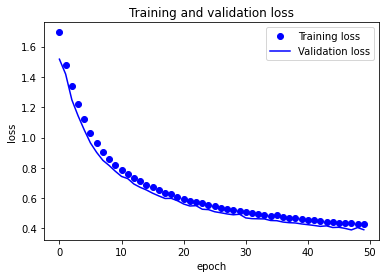

In [13]:
# plot loss curve on validation data
loss = SCDA_train.history['loss']
val_loss = SCDA_train.history['val_loss']
plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

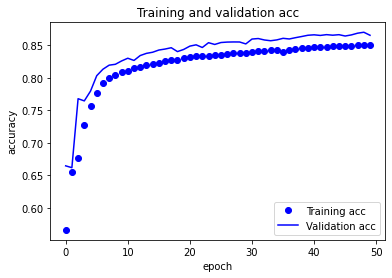

In [14]:
# plot accuracy curve on validation data
acc = SCDA_train.history['accuracy']
val_acc = SCDA_train.history['val_accuracy']
plt.figure()
plt.plot(range(len(acc)), acc, 'bo', label='Training acc')
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

From the above plot, you may derive some intuition that the model is not overfitting at the most epochs and is not really at sync. For sure you may try to improve the performance of the SCDA model by introducing some complexity into it, so that the loss can be reduced more significantly, by means of training it for more epochs, i.e. 1000, put a greater batch size, play with the kernels of convolutional layers and then decide on the result obtained. All in all, the accuracy of the model being generated at 50 epochs performs pretty well comparing to the other presented widely used standard imputation techniques. 

Anyway, this kernel combination [32, 64, 128, 128, 64, 3] has a better performance than the kernel combination of [16, 32, 64, 64, 32, 3] and slightly a lower performance than [48, 96, 128, 128, 96, 3], having gained an accuracy of 0.8506 comparing to the score of 0.840 and 0.8542, respectively.

KNN

In [ ]:
MaizeData_X = pd.read_csv('data_set.data/dataverse_files/Geno_50K_Drops_012_247I_44729L.tsv', sep='\t')
df_ori = MaizeData_X

In [ ]:
display(MaizeData_X.isna().sum())
display(MaizeData_X.isna().sum().sum() / (len(MaizeData_X) * len(MaizeData_X.columns)))

SYN83                     0
PZE-101000060             0
PZE-101000088             0
PZE-101000108             0
PZE-101000111             0
                         ..
SYNGENTA16702             0
SYNGENTA1627              0
PUT-163a-89757491-4674    0
PUT-163a-18163661-1262    0
PZA03171.3                0
Length: 44729, dtype: int64

0.0

In [ ]:
df_incomplete = df_ori.copy()
# masking artificially
mask = np.random.choice([1, 0], df_incomplete.shape, p=[.1, .9]).astype(bool)
df_incomplete[mask] = np.nan

In [ ]:
%%time
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 10)
imputed = imputer.fit_transform(df_incomplete)
df_imputed = pd.DataFrame(imputed, columns = df_incomplete.columns,index = df_incomplete.index)

In [ ]:
df_imputed = df_imputed.astype(int)

In [ ]:
incorrect = (df_imputed != df_ori)
incorrect_cnts = incorrect.apply(pd.value_counts)
incorrect_sum = incorrect_cnts.sum(axis=1)
incorrect_sum[1]

missing = df_incomplete.apply(pd.isnull)
missing_cnts = missing.apply(pd.value_counts)
missing_sum = missing_cnts.sum(axis=1)

In [ ]:
accuracy = 1 - (incorrect_sum[1] / missing_sum[1])
print(accuracy)

0.6129246270088664


SVD

In [ ]:
!pip install fancyimpute

     |████████████████████████████████| 154 kB 13.7 MB/s 
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=3c6501713dd4ad9110ed5af109f675ac30533145f56940a36ad756d150a54385
  Stored in directory: /root/.cache/pip/wheels/e3/04/06/a1a7d89ef4e631ce6268ea2d8cde04f7290651c1ff1025ce68
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=1f511d3946a64156417e68f4381f2b5ab045c37228e61810036d92451f4ad8da
  Stored in directory: /root/.cache/pip/wheels/72/21/a8/a045cacd9838abd5643f6bfa852c0796a99d6b1494760494e0
Successfully built fancyimpute knnimpute


In [ ]:
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
from fancyimpute import IterativeSVD

In [ ]:
df_incomplete = df_ori.copy()
mask = np.random.choice([1, 0], df_incomplete.shape, p=[.1, .9]).astype(bool)
df_incomplete[mask] = np.nan

In [ ]:
#n_row = df_incomplete.shape[1] # dimensionality of data space
#non_missing_row_ind= np.where(np.isfinite(np.sum(df_incomplete,axis=1)))
#non_missing_row_ind

In [ ]:
na_ind = np.where(np.isnan(df_incomplete))
na_ind

(array([  0,   0,   0, ..., 246, 246, 246]),
 array([    6,    16,    24, ..., 44720, 44722, 44728]))

In [ ]:
na_count= len(na_ind[0])
na_count

1104855

In [ ]:
data_impute_SVD = IterativeSVD(rank=247, convergence_threshold=0.0005, max_iters=8).fit_transform(df_incomplete)
ReconstructionErrorSVD = sum(((data_impute_SVD[na_ind] - MaizeData_X[na_ind])**2)**0.5)/na_count
#print('Reconstruction error (VAE):')
#print(ReconstructionErrorSVD) 

[IterativeSVD] Iter 1: observed MAE=0.686614
[IterativeSVD] Iter 2: observed MAE=0.653070
[IterativeSVD] Iter 3: observed MAE=0.613117
[IterativeSVD] Iter 4: observed MAE=0.561531
[IterativeSVD] Iter 5: observed MAE=0.514555
[IterativeSVD] Iter 6: observed MAE=0.458353
[IterativeSVD] Iter 7: observed MAE=0.381017
[IterativeSVD] Iter 8: observed MAE=0.240036


In [ ]:
!pip install impyute

Mice

In [ ]:
MaizeData_X = pd.read_csv('data_set.data/dataverse_files/Geno_50K_Drops_012_247I_44729L.tsv', sep='\t')
df_ori = MaizeData_X
MaizeData_X

,SYN83,PZE-101000060,PZE-101000088,PZE-101000108,PZE-101000111,PZE-101000161,PZE-101000169,PZE-101000209,PZE-101000256,PZE-101000301,...,ZM013608-0315,PZE-101235343,PUT-163a-28982443-1666,PZA00086.8,ZM013526-0477,SYNGENTA16702,SYNGENTA1627,PUT-163a-89757491-4674,PUT-163a-18163661-1262,PZA03171.3
11430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A3,0,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,2,2,2,0,0
A310,2,0,0,2,0,0,0,0,2,2,...,0,2,2,2,0,2,0,0,2,0
A347,2,2,0,2,2,0,0,0,2,0,...,0,0,0,0,0,2,0,0,2,0
A374,2,2,0,2,0,2,2,2,0,2,...,0,2,2,2,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W604S,0,0,0,2,2,0,0,2,2,0,...,2,0,0,2,0,2,0,2,2,0
W64A,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,2,2,0,0,0
W9,2,0,0,2,0,0,2,2,0,2,...,0,0,0,2,0,2,0,2,0,0
W95115,0,0,0,2,0,0,0,2,2,0,...,0,2,2,2,0,2,2,2,2,0


In [ ]:
df_incomplete = df_ori.iloc[:,0:500] 
mask = np.random.choice([1, 0], df_incomplete.shape, p=[.1, .9]).astype(bool)
df_incomplete[mask] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=42)
df_mice = imp.fit_transform(df_incomplete)

[IterativeImputer] Completing matrix with shape (247, 500)
[IterativeImputer] Ending imputation round 1/10, elapsed time 23.39
[IterativeImputer] Change: 51.74104578514026, scaled tolerance: 0.002 
[IterativeImputer] Ending imputation round 2/10, elapsed time 42.85
[IterativeImputer] Change: 29.929265778535846, scaled tolerance: 0.002 
[IterativeImputer] Ending imputation round 3/10, elapsed time 63.07
[IterativeImputer] Change: 21.811512540109057, scaled tolerance: 0.002 
[IterativeImputer] Ending imputation round 4/10, elapsed time 82.73
[IterativeImputer] Change: 14.081628202467229, scaled tolerance: 0.002 
[IterativeImputer] Ending imputation round 5/10, elapsed time 102.44
[IterativeImputer] Change: 9.95737613979322, scaled tolerance: 0.002 
[IterativeImputer] Ending imputation round 6/10, elapsed time 122.50
[IterativeImputer] Change: 6.465068141911082, scaled tolerance: 0.002 
[IterativeImputer] Ending imputation round 7/10, elapsed time 143.00
[IterativeImputer] Change: 5.28855

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [ ]:
df_mice

array([[ 0.        ,  0.19230348,  0.        , ...,  0.        ,
         0.        ,  0.90851885],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  3.03757516],
       [ 2.        ,  0.        ,  0.        , ...,  2.        ,
         2.        ,  2.        ],
       ...,
       [ 2.        ,  0.        ,  0.        , ...,  2.        ,
         2.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.79076652,
         2.        ,  2.        ],
       [ 0.        ,  0.        , -0.0237551 , ...,  0.        ,
         1.92066015,  1.94162868]])

Mean

In [ ]:
df_incomplete = df_ori.copy()
mask = np.random.choice([1, 0], df_incomplete.shape, p=[.1, .9]).astype(bool)
df_incomplete[mask] = np.nan 
df_imputed_mean = df_incomplete.fillna(df_incomplete.mean())

In [ ]:
df_imputed_mean = df_imputed_mean.astype(int)

In [ ]:
df_imputed_mean

,SYN83,PZE-101000060,PZE-101000088,PZE-101000108,PZE-101000111,PZE-101000161,PZE-101000169,PZE-101000209,PZE-101000256,PZE-101000301,...,ZM013608-0315,PZE-101235343,PUT-163a-28982443-1666,PZA00086.8,ZM013526-0477,SYNGENTA16702,SYNGENTA1627,PUT-163a-89757491-4674,PUT-163a-18163661-1262,PZA03171.3
11430,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
A3,0,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,2,2,0,0,0
A310,2,0,0,2,0,0,0,0,2,2,...,0,2,2,2,0,2,0,0,2,0
A347,2,2,0,2,2,0,0,0,2,0,...,0,0,0,0,0,2,0,0,2,0
A374,2,2,0,2,0,2,2,2,0,2,...,0,2,2,2,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W604S,1,0,0,2,2,0,0,2,2,0,...,2,0,0,2,0,1,0,2,0,0
W64A,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,0,2,2,0,0,0
W9,2,0,0,2,0,0,2,2,0,2,...,0,0,0,0,0,2,0,2,0,0
W95115,0,0,0,2,0,0,0,2,2,0,...,0,2,0,0,0,1,2,0,2,0


In [ ]:
incorrect = (df_imputed_mean != df_ori)
incorrect_cnts = incorrect.apply(pd.value_counts)
incorrect_sum = incorrect_cnts.sum(axis=1)
incorrect_sum[1]

missing = df_incomplete.apply(pd.isnull)
missing_cnts = missing.apply(pd.value_counts)
missing_sum = missing_cnts.sum(axis=1)

accuracy = 1 - (incorrect_sum[1] / missing_sum[1])
print(accuracy)

0.5798931999373576


Median

In [ ]:
df_incomplete = df_ori.copy()
mask = np.random.choice([1, 0], df_incomplete.shape, p=[.1, .9]).astype(bool)
df_incomplete[mask] = np.nan
df_imputed_median=df_incomplete.fillna(df_incomplete.median())
# with the probability being 0.1 it will assign 0, then mask

df_imputed_median=df_imputed_median.astype(int)

incorrect = (df_imputed_median != df_ori)
incorrect_cnts = incorrect.apply(pd.value_counts)
incorrect_sum = incorrect_cnts.sum(axis=1)
incorrect_sum[1]
##
missing = df_incomplete.apply(pd.isnull)
missing_cnts = missing.apply(pd.value_counts)
missing_sum = missing_cnts.sum(axis=1)

accuracy = 1 - (incorrect_sum[1] / missing_sum[1])
print(accuracy)

0.7192487217974364


Mode

In [ ]:
df_incomplete = df_ori.copy()
mask = np.random.choice([1, 0], df_incomplete.shape, p=[.1, .9]).astype(bool)
df_incomplete[mask] = np.nan
df_incomplete_mode=df_incomplete.copy()
for i in df_ori.columns:
  df_incomplete_mode[i] = df_incomplete_mode[i].fillna(df_incomplete_mode[i].mode()[0])

df_incomplete_mode=df_incomplete_mode.astype(int)

incorrect = (df_incomplete_mode != df_ori)
incorrect_cnts = incorrect.apply(pd.value_counts)
incorrect_sum = incorrect_cnts.sum(axis=1)
incorrect_sum[1]
##
missing = df_incomplete.apply(pd.isnull)
missing_cnts = missing.apply(pd.value_counts)
missing_sum = missing_cnts.sum(axis=1)

accuracy = 1 - (incorrect_sum[1] / missing_sum[1])
print(accuracy)

0.7262999321420494


In [ ]:
# creating a HDF5 file 'SCDA.h5'
SCDA.save('model/SCDA.h5')  